## 安装方式(release的最新版本)： 
安装vnpy_fxdayu:

https://github.com/xingetouzi/vnpy_fxdayu/tree/release-1.1.13.dev1811227

## 配置引擎参数

In [1]:
import pandas as pd
import warnings
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import talib as ta
from talib import abstract

In [3]:
from vnpy.trader.app.ctaStrategy import BacktestingEngine

# 创建回测引擎对象
engine = BacktestingEngine()

# 设置回测使用的数据
engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
engine.setDatabase('VnTrader_1Min_Db')  # 设置使用的历史数据库
engine.setStartDate('20180601 12:00',initHours=200) # 设置回测用的数据起始日期
engine.setEndDate('20181130 12:00') # 设置回测用的数据终止日期

# 配置回测引擎参数
engine.setSlippage(0.002)    # 设置滑点
engine.setRate(5/10000)   # 设置手续费千1
engine.setCapital(1000000)  # 设置回测本金

In [11]:
from vnpy.trader.app.ctaStrategy import BacktestingEngine
import pandas as pd

def runBacktesting(strategyClass, settingDict,
                   startDate, endDate, slippage, rate):
    engine = BacktestingEngine()
    engine.setBacktestingMode(engine.BAR_MODE)  # 设置引擎的回测模式为K线
    engine.setDatabase('VnTrader_3Min_Db')    # 设置使用的历史数据库
    engine.setStartDate(startDate, initHours=200)   # 设置回测用的数据起始日期
    engine.setEndDate(endDate)     # 设置回测用的数据结束日期
    engine.setSlippage(slippage)    # 设置滑点
    engine.setRate(rate)             # 设置手续费万0.3
    engine.initStrategy(strategyClass, settingDict)
    engine.setCapital(100000)     # 设置回测本金
    engine.runBacktesting()
    #显示逐日回测结果
    engine.showDailyResult()
    #显示逐笔回测结果
    engine.showBacktestingResult()
    # 计算回测结果
    df = engine.calculateDailyResult()
    return df

## 策略编写与参数设置

参数与变量的区别: 参数用来传递并且可以优化，变量是随着过程的赋值改变的

## CtaTemplate 继承的属性与方法
1. self.symbolList: 支持多品种以列表格式输入引擎
2. self.posDict: 可记录多个品种的多空持仓的字典
3. self.cancelAll(): 取消所有订单
4. self.getArrayManager(symbol, freq): 数组管理器

In [5]:
from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta

########################################################################
# 策略继承CtaTemplate
class MultiSignalStrategy(CtaTemplate):
    className = 'MultiSignalStrategy'
    author = 'LuYiming'
    
   # 参数设置
    short_roc_period = 9
    fastPeriod = 5; slowPeriod = 30
    roc_period = 20
    roc_10_ma1_period = 10;roc_10_ma2_period = 22
    roc_ma1_period = 5;roc_ma2_period = 25
    trailingPct = 0.04
    stopRatio = 0.03    # 止损率
    lot = 1
    
    # 策略变量
    transactionPrice = {} # 记录成交价格
    RSI = {};CCI = {};ROC_MA = {};VWAP = {}
    
    
    # 参数列表
    paramList = ['short_roc_period','roc_period','roc_10_ma1_period','roc_10_ma2_period','stopRatio','fastPeriod','slowPeriod']    
    
    # 变量列表
    varList = ['transactionPrice','intraTradeHighDict', 'intraTradeLowDict',
              'CCI', 'VWAP', 'ROC_MA']  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        # 首先找到策略的父类（就是类CtaTemplate），然后把DoubleMaStrategy的对象转换为类CtaTemplate的对象
        super().__init__(ctaEngine, setting)
      
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList}
        self.intraTradeHighDict = {s:0 for s in self.symbolList}
        self.intraTradeLowDict = {s:999999 for s in self.symbolList}
        self.RSI = {s:0 for s in self.symbolList}
        self.VWAP = {s:0 for s in self.symbolList}
        self.ROC_MA = {s:0 for s in self.symbolList}
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
        
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送"""
        symbol = bar.vtSymbol
        
        # 洗价器（止盈止损）
        if self.posDict[symbol+'_LONG'] == 0 and self.posDict[symbol+'_SHORT'] == 0:
            self.intraTradeHighDict[symbol] = 0
            self.intraTradeLowDict[symbol] = 999999

        # 持有多头仓位
        elif self.posDict[symbol+'_LONG'] >0:
            self.intraTradeHighDict[symbol] = max(self.intraTradeHighDict[symbol], bar.high)
            self.longStop = self.intraTradeHighDict[symbol]*(1-self.trailingPct)
            if bar.close<=self.longStop:
                self.cancelAll()
                self.sell(symbol, bar.close*0.9, self.posDict[symbol+'_LONG'])

#         # 持有空头仓位
        elif self.posDict[symbol+'_SHORT'] >0:
            self.intraTradeLowDict[symbol] = min(self.intraTradeLowDict[symbol], bar.low)
            self.shortStop = self.intraTradeLowDict[symbol]*(1+self.trailingPct)
            if bar.close>=self.shortStop:
                self.cancelAll()
                self.cover(symbol, bar.close*1.1, self.posDict[symbol+'_SHORT'])
        self.putEvent()
    
    #----------------------------------------------------------------------
    
    def on15MinBar(self, bar):
        symbol = bar.vtSymbol
        am15 = self.getArrayManager(symbol, "15m")
        
        if not am15.inited:
            return
        fastMa = ta.MA(am15.close, self.fastPeriod)
        slowMa = ta.MA(am15.close, self.slowPeriod)
        if (fastMa[-1] > slowMa[-1]) and (fastMa[-2] < slowMa[-2]):
            self.RSI[symbol] = 1
        elif (fastMa[-1] < slowMa[-1]) and (fastMa[-2] > slowMa[-2]):
            self.RSI[symbol] = -1
            
        ROC_10 = ta.ROC(am15.close, self.short_roc_period)
        roc_10_ma1 = ta.MA(ROC_10, self.roc_10_ma1_period)
        roc_10_ma2 = ta.MA(ROC_10, self.roc_10_ma2_period)
        
        if (roc_10_ma1[-1] > roc_10_ma2[-1]) and (roc_10_ma1[-2] <= roc_10_ma2[-2]):
            self.RSI[symbol] += 1
        elif (roc_10_ma1[-1] < roc_10_ma2[-1]) and (roc_10_ma1[-2] >= roc_10_ma2[-2]):
            self.RSI[symbol] += -1
        else:
            self.RSI[symbol] = 0
        
#         # 发出状态更新事件
        self.putEvent()
        
    def on60minBar(self, bar):
        """收到60分钟Bar推送"""
        symbol = bar.vtSymbol
        
        am60 = self.getArrayManager(symbol, "60m") # 获取历史数组
        
        if not am60.inited:
            return
        
        # 计算策略需要的信号-------------------------------------------------
        ROC = ta.ROC(am60.close, self.roc_period)
        
        roc_ma1 = ta.MA(ROC, self.roc_ma1_period)
        roc_ma2 = ta.MA(ROC, self.roc_ma2_period)
        
        # 现象条件
        if (roc_ma1[-1] > roc_ma2[-1]) and (roc_ma1[-2] <= roc_ma2[-2]):
            self.ROC_MA[symbol] = 1
        elif (roc_ma1[-1] < roc_ma2[-1]) and (roc_ma1[-2] >= roc_ma2[-2]):
            self.ROC_MA[symbol] = -1
        else:
            self.ROC_MA[symbol] = 0
        
        Signal = self.RSI[symbol]
        
        # 进出场条件(self.RSI[symbol]>=1) and 
        if (self.ROC_MA[symbol]==1):
            if self.posDict[symbol + "_SHORT"] == 0:
                self.buy(symbol, bar.close * 1.05, self.lot)
            elif self.posDict[symbol + "_SHORT"] > 0:
                self.cover(symbol, bar.close * 1.05, self.posDict[symbol + "_SHORT"])
                self.buy(symbol, bar.close * 1.05, self.lot)
        elif (self.ROC_MA[symbol]==-1):
            if self.posDict[symbol + "_LONG"] == 0:
                self.short(symbol, bar.close * 0.95, self.lot)
            elif self.posDict[symbol + "_LONG"] > 0:
                self.sell(symbol, bar.close * 0.95, self.posDict[symbol + "_LONG"])
                self.short(symbol, bar.close *0.95, self.lot)
        elif ((Signal>=1) and (self.ROC_MA[symbol]==-1)) or ((self.ROC_MA[symbol]==1) and (Signal<=-1)):
            # 有多平多，有空平空
            if self.posDict[symbol+'_LONG'] > 0:
                self.cancelAll()
                self.sell(symbol, bar.close*0.95, self.posDict[symbol+'_LONG'])
            elif self.posDict[symbol+'_SHORT'] > 0:
                self.cancelAll()
                self.cover(symbol, bar.close*1.05, self.posDict[symbol+'_SHORT'])
        
        # 进出场条件
#         if breakUp_roc and (self.posDict[symbol + "_LONG"]==0):
#             if self.posDict[symbol + "_SHORT"] == 0:
#                 self.buy(symbol, bar.close * 1.01, self.lot)
#             elif self.posDict[symbol + "_SHORT"] > 0:
#                 self.cover(symbol, bar.close * 1.01, self.posDict[symbol + "_SHORT"])
#                 self.buy(symbol, bar.close * 1.01, self.lot)
#         elif breakDn_roc and (self.posDict[symbol + "_SHORT"]==0):
#             if self.posDict[symbol + "_LONG"] == 0:
#                 self.short(symbol, bar.close * 0.9, self.lot)
#             elif self.posDict[symbol + "_LONG"] > 0:
#                 self.sell(symbol, bar.close * 0.98, self.posDict[symbol + "_LONG"])
#                 self.short(symbol, bar.close *0.98, self.lot)
                
        # 发出状态更新事件
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
2018-12-23 01:36:23.125630	开始回测
2018-12-23 01:36:23.126627	策略初始化
2018-12-23 01:36:23.691150	数据载入完成, 时间段:[20180524 04:00,20180601 12:00);数据量:12000
2018-12-23 01:36:23.691150	初始化预加载数据成功, 数据长度:12000
2018-12-23 01:36:23.691150	策略初始化完成
2018-12-23 01:36:23.691150	策略启动完成
2018-12-23 01:36:23.691150	回测时间范围:[20180601 12:00,20181130 12:00)
2018-12-23 01:36:23.691150	当前回放的时间段:[20180601 12:00,20181130 12:00)
2018-12-23 01:36:39.278418	数据载入完成, 时间段:[20180601 12:00,20181130 12:00);数据量:260288
2018-12-23 01:36:39.659399	数据载入完成, 时间段:[20180531 20:51,20180603 12:01);数据量:3790
2018-12-23 01:36:42.656384	数据载入完成, 时间段:[20180424 15:00,20180531 20:50);数据量:44469
2018-12-23 01:36:42.667354	WARNING: 该时间段:[20180603 12:01,20180603 13:00) 数据量为0!
2018-12-23 01:37:09.457689	回放结束ress: 100%    
2018-12-23 01:37:09.458688	计算按日统计结果
2018-12-23 01:37:09.482624	------------------------------
2018-12-23 01:37:09.482624	首个交易日：	2018-06-01 00:00:00
2018-12-23 0

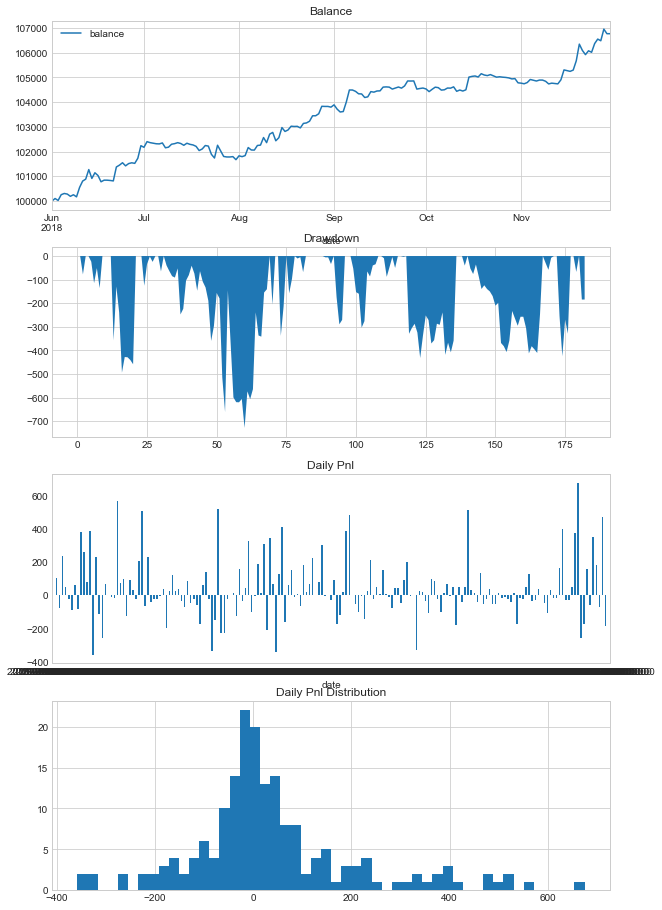

2018-12-23 01:37:12.933390	计算回测结果
2018-12-23 01:37:12.974283	------------------------------
2018-12-23 01:37:12.974283	第一笔交易：	2018-06-03 11:00:00
2018-12-23 01:37:12.975279	最后一笔交易：	2018-11-29 17:11:00
2018-12-23 01:37:12.975279	总交易次数：	228
2018-12-23 01:37:12.975279	总盈亏：	6,771.65
2018-12-23 01:37:12.975279	最大回撤: 	-889.67
2018-12-23 01:37:12.975279	平均每笔盈利：	29.7
2018-12-23 01:37:12.975279	平均每笔滑点：	0.0
2018-12-23 01:37:12.975279	平均每笔佣金：	6.58
2018-12-23 01:37:12.975279	胜率		42.11%
2018-12-23 01:37:12.975279	盈利交易平均值	152.72
2018-12-23 01:37:12.975279	亏损交易平均值	-59.77
2018-12-23 01:37:12.975279	盈亏比：	2.56


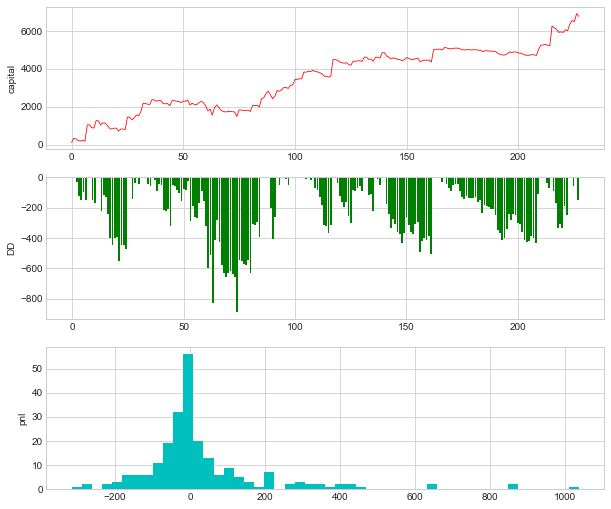

2018-12-23 01:37:13.689407	计算按日统计结果


,netPnl,slippage,commission,turnover,tradeCount,tradingPnl,positionPnl,totalPnl
date,,,,,,,,
2018-06-01,0.000000,0.000,0.000000,0.00,0,0.00,0.00,0.00
2018-06-02,101.419040,0.002,3.758960,7517.92,1,105.18,0.00,105.18
2018-06-03,-77.915420,0.004,7.641420,15282.84,2,-177.18,106.91,-70.27
2018-06-04,233.020000,0.000,0.000000,0.00,0,0.00,233.02,233.02
2018-06-05,48.698570,0.006,11.105430,22210.86,3,139.91,-80.10,59.81
2018-06-06,-24.326995,0.002,3.814995,7629.99,1,-20.51,0.00,-20.51
2018-06-07,-90.586400,0.004,7.712400,15424.80,2,-41.94,-40.93,-82.87
2018-06-08,63.680840,0.004,7.695160,15390.32,2,135.30,-63.92,71.38
2018-06-09,-84.989630,0.008,15.231630,30463.26,4,-87.26,17.51,-69.75


In [13]:
# 在引擎中创建策略对象
parameterDict = {'symbolList':['BTCUSDT:binance']} # 策略参数配置
# engine.initStrategy(Strategy, parameterDict)    # 创建策略对象
# engine.runBacktesting()
runBacktesting(MultiSignalStrategy, parameterDict, '20180601 12:00', '20181130 12:00', 0.002, 5/10000)

仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种EOSUSDT:binance上的on_60min_bar函数functools.partial(<function MultiSignalStrategy.on60minBar at 0x0000022AD6AAA7B8>, <__main__.MultiSignalStrategy object at 0x0000022AD5FEBB00>)
[DEBUG] 注册品种EOSUSDT:binance上的on_15Min_bar函数functools.partial(<function MultiSignalStrategy.on15MinBar at 0x0000022AD6AAA2F0>, <__main__.MultiSignalStrategy object at 0x0000022AD5FEBB00>)
[DEBUG] 注册品种EOSUSDT:binance上的on_1m_bar函数functools.partial(<function MultiSignalStrategy.onBar at 0x0000022AD6AAA8C8>, <__main__.MultiSignalStrategy object at 0x0000022AD5FEBB00>)
2018-12-18 00:28:43.733266	开始回测
2018-12-18 00:28:43.733266	策略初始化
2018-12-18 00:28:43.736257	载入历史数据。数据范围:[20180623 04:00,20180701 12:00)
2018-12-18 00:28:44.210987	 当前品种 EOSUSDT:binance 的数据，全部来自于本地缓存
2018-12-18 00:28:44.214012	载入完成，数据量：11295
2018-12-18 00:28:44.214012	策略初始化完成
2018-12-18 00:28:44.214012	策略启动完成
2018-12-18 00:28:44.214012	开始回放回测数据,回测范围:[20180701 12:00,20181130

Traceback (most recent call last):
  File "G:\Anaconda\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "G:\Anaconda\lib\site-packages\pandas\core\generic.py", line 2970, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


2018-12-18 00:28:53.000484	 当前品种 EOSUSDT:binance 的数据，全部来自于本地缓存
2018-12-18 00:28:53.004471	载入完成，数据量：3790
[INFO] 品种EOSUSDT:binance的历史1mK线更新，范围为:[20180701102100 , 20180701120000]
[INFO] 品种EOSUSDT:binance的1mK线准备就绪,当前K线时间为20180701120000
[INFO] 品种EOSUSDT:binance开始生成未完成的60mK线数据,时间起点为:20180701120000
2018-12-18 00:28:53.030401	载入历史数据。数据范围:[20180524 15:00,20180630 20:50)
2018-12-18 00:28:54.925335	失去MongoDB的连接，我们尝试使用本地缓存数据，请注意数据量
2018-12-18 00:28:54.936309	载入完成，数据量：47285
2018-12-18 00:28:54.941293	载入历史数据。数据范围:[20180703 12:01,20180703 13:00)
2018-12-18 00:28:54.950267	 当前品种 EOSUSDT:binance 的数据，全部来自于本地缓存
2018-12-18 00:28:54.950267	！！ 数据量为 0 ！！


Traceback (most recent call last):
  File "G:\Anaconda\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "G:\Anaconda\lib\site-packages\pandas\core\generic.py", line 2970, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180627070000 , 20180701110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180701120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180630110000 , 20180701114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180701120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180701120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180701120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 7.9618, 'high': 7.9785, 'low': 7.9555, 'close': 7.9666, 'date': '20180701', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 7, 1, 12, 0), 'volume': 76756.84999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180630111500 , 20180701120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180701120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 7.9618, 'high'

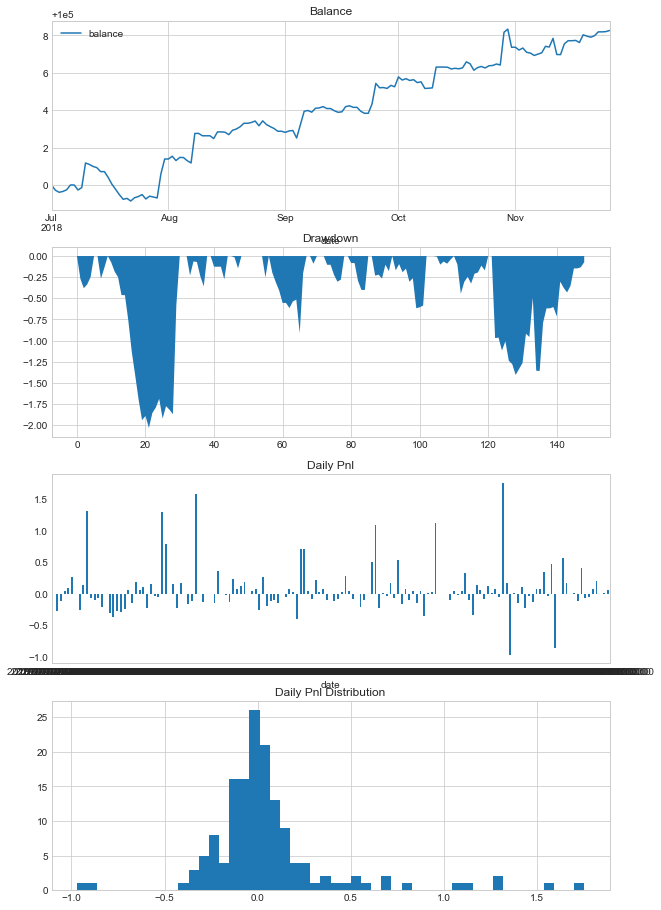

2018-12-18 00:29:12.327798	计算回测结果
2018-12-18 00:29:12.338767	------------------------------
2018-12-18 00:29:12.338767	第一笔交易：	2018-07-02 21:27:00
2018-12-18 00:29:12.338767	最后一笔交易：	2018-11-26 23:58:00
2018-12-18 00:29:12.338767	总交易次数：	101
2018-12-18 00:29:12.338767	总盈亏：	8.26
2018-12-18 00:29:12.338767	最大回撤: 	-1.87
2018-12-18 00:29:12.338767	平均每笔盈利：	0.08
2018-12-18 00:29:12.338767	平均每笔滑点：	0.0
2018-12-18 00:29:12.339773	平均每笔佣金：	0.01
2018-12-18 00:29:12.339773	胜率		49.5%
2018-12-18 00:29:12.339773	盈利交易平均值	0.3
2018-12-18 00:29:12.339773	亏损交易平均值	-0.13
2018-12-18 00:29:12.339773	盈亏比：	2.3


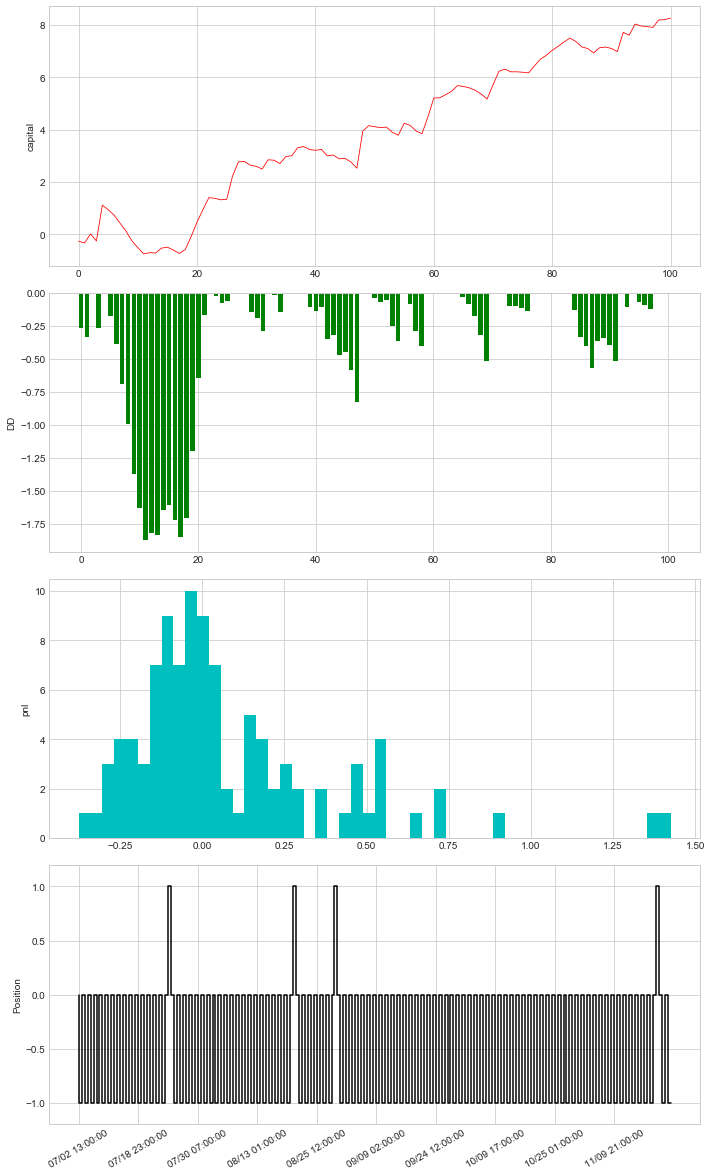

2018-12-18 00:29:13.085772	计算按日统计结果


,netPnl,slippage,commission,turnover,tradeCount,tradingPnl,positionPnl,totalPnl
date,,,,,,,,
2018-07-01,0.000000,0.000,0.000000,0.0000,0,0.0000,0.0000,0.0000
2018-07-02,-0.268672,0.004,0.008072,16.1434,2,-0.2566,0.0000,-0.2566
2018-07-03,-0.112047,0.002,0.004447,8.8934,1,-0.1056,0.0000,-0.1056
2018-07-04,0.045026,0.002,0.004474,8.9475,1,0.1870,-0.1355,0.0515
2018-07-05,0.089475,0.002,0.004525,9.0498,1,0.0960,0.0000,0.0960
2018-07-06,0.256555,0.002,0.004345,8.6909,1,-0.1350,0.3979,0.2629
2018-07-07,0.000000,0.000,0.000000,0.0000,0,0.0000,0.0000,0.0000
2018-07-08,-0.268072,0.004,0.008572,17.1445,2,-0.2555,0.0000,-0.2555
2018-07-09,0.128630,0.002,0.004370,8.7401,1,0.1350,0.0000,0.1350


In [38]:
# 在引擎中创建策略对象
parameterDict = {'symbolList':['EOSUSDT:binance']} # 策略参数配置
# engine.initStrategy(Strategy, parameterDict)    # 创建策略对象
# engine.runBacktesting()
runBacktesting(MultiSignalStrategy, parameterDict, '20180701 12:00', '20181130 12:00', 0.002, 5/10000)

In [27]:
from vnpy.trader.app.ctaStrategy.ctaBacktesting  import OptimizationSetting
# 优化配置
setting = OptimizationSetting()                # 新建一个优化任务设置对象
setting.setOptimizeTarget('sharpeRatio')       # 设置优化排序的目标是夏普
setting.addParameter('short_roc_period', 8, 12, 1)
setting.addParameter('roc_10_ma1_period', 6, 12, 2)    # 增加第一个优化参数，起始30，结束50，步进10
setting.addParameter('roc_10_ma2_period', 18, 24, 2)    # 增加第二个优化参数，起始60，结束30，步进10

setting.addParameter('symbolList', ['BTCUSDT:binance']) 

import time
start = time.time()
# 执行单线程优化
resultList = engine.runOptimization(MultiSignalStrategy, setting)
# 执行多进程优化一般会改写成py文件然后用多线程运行，提高优化速度。
# resultList = engine.runParallelOptimization(Strategy, setting)
# print('耗时：%s' %(time.time()-start))

2018-12-17 23:36:59.081180	------------------------------
2018-12-17 23:36:59.081180	setting: {'short_roc_period': 8, 'roc_10_ma1_period': 6, 'roc_10_ma2_period': 18, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60min_bar函数functools.partial(<function MultiSignalStrategy.on60minBar at 0x0000022AB25FC2F0>, <__main__.MultiSignalStrategy object at 0x0000022AB907FEF0>)
[DEBUG] 注册品种BTCUSDT:binance上的on_15Min_bar函数functools.partial(<function MultiSignalStrategy.on15MinBar at 0x0000022ABE8B49D8>, <__main__.MultiSignalStrategy object at 0x0000022AB907FEF0>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiSignalStrategy.onBar at 0x0000022AB25FCA60>, <__main__.MultiSignalStrategy object at 0x0000022AB907FEF0>)
2018-12-17 23:36:59.108108	开始回测
2018-12-17 23:36:59.108108	策略初始化
2018-12-17 23:36:59.109104	载入历史数据。数据范围:[20180524 04:00,20180601 12:00)
2018-12-17 23:36:59.547932	 当前品种 BTCU

2018-12-17 23:37:55.788531	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 23:37:55.792520	载入完成，数据量：12000
2018-12-17 23:37:55.792520	策略初始化完成
2018-12-17 23:37:55.792520	策略启动完成
2018-12-17 23:37:55.792520	开始回放回测数据,回测范围:[20180601 12:00,20181123 12:00)
2018-12-17 23:37:55.814462	载入历史数据。数据范围:[20180601 12:00,20181123 12:00)
2018-12-17 23:38:05.511536	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 23:38:05.576359	载入完成，数据量：250208
2018-12-17 23:38:05.576359	当前回放数据:[20180601 12:00,20181123 12:00)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180601120000
2018-12-17 23:38:05.578389	载入历史数据。数据范围:[20180531 20:51,20180603 12:01)
2018-12-17 23:38:05.736961	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 23:38:05.737927	载入完成，数据量：3790
[INFO] 品种BTCUSDT:binance的历史1mK线更新，范围为:[20180601102100 , 20180601120000]
[INFO] 品种BTCUSDT:binance的1mK线准备就绪,当前K线时间为20180601120000
[INFO] 品种BTCUSDT:binance开始生成未完成的60mK线数据,时间起点为:20180601120000
2018-12-17 23:38:05.757905	载入历史数据。数据范围:[20180424 15:00,20180531 20:50)
2018-12-17 23:3

2018-12-17 23:38:59.335596	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 23:38:59.345571	载入完成，数据量：44469
2018-12-17 23:38:59.349559	载入历史数据。数据范围:[20180603 12:01,20180603 13:00)
2018-12-17 23:38:59.358535	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 23:38:59.358535	！！ 数据量为 0 ！！
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180531110000 , 20180601114500]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成15mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7483.45, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 294.761681, 'openInterest': 0}
[INFO] 

[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7491.22, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 962.8287040000002, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528090000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的60mK线准备就绪,当前K线时间为20180601120000
2018-12-17 23:40:10.547173	数据回放结束ss: 100%    
2018-12-17 23:40:10.547173	计算按日统计结果
2018-12-17 23:40:10.723689	------------------------------
2018-12-17 23:40:10.724686	setting: {'short_roc_period': 8, 'roc_10_ma1_period': 8, 'roc_10_ma2_period': 24, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60min_bar函数functools.partial(<function MultiSignalStrategy.on60minBar at 0x0000022ACF830378>, <__main__.MultiSignalStrategy object at 0x00

2018-12-17 23:41:07.941679	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 23:41:07.944669	载入完成，数据量：12000
2018-12-17 23:41:07.945666	策略初始化完成
2018-12-17 23:41:07.945666	策略启动完成
2018-12-17 23:41:07.945666	开始回放回测数据,回测范围:[20180601 12:00,20181123 12:00)
2018-12-17 23:41:07.965646	载入历史数据。数据范围:[20180601 12:00,20181123 12:00)
2018-12-17 23:41:17.522058	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 23:41:17.585888	载入完成，数据量：250208
2018-12-17 23:41:17.586885	当前回放数据:[20180601 12:00,20181123 12:00)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180601120000
2018-12-17 23:41:17.587880	载入历史数据。数据范围:[20180531 20:51,20180603 12:01)
2018-12-17 23:41:17.763414	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 23:41:17.764409	载入完成，数据量：3790
[INFO] 品种BTCUSDT:binance的历史1mK线更新，范围为:[20180601102100 , 20180601120000]
[INFO] 品种BTCUSDT:binance的1mK线准备就绪,当前K线时间为20180601120000
[INFO] 品种BTCUSDT:binance开始生成未完成的60mK线数据,时间起点为:20180601120000
2018-12-17 23:41:17.783391	载入历史数据。数据范围:[20180424 15:00,20180531 20:50)
2018-12-17 23:4

2018-12-17 23:42:14.236392	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 23:42:14.250356	载入完成，数据量：44469
2018-12-17 23:42:14.256341	载入历史数据。数据范围:[20180603 12:01,20180603 13:00)
2018-12-17 23:42:14.266313	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 23:42:14.266313	！！ 数据量为 0 ！！
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180531110000 , 20180601114500]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成15mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7483.45, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 294.761681, 'openInterest': 0}
[INFO] 

[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7491.22, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 962.8287040000002, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528090000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的60mK线准备就绪,当前K线时间为20180601120000
2018-12-17 23:43:21.203309	数据回放结束ss: 100%    
2018-12-17 23:43:21.203309	计算按日统计结果
2018-12-17 23:43:21.316007	------------------------------
2018-12-17 23:43:21.316007	setting: {'short_roc_period': 8, 'roc_10_ma1_period': 12, 'roc_10_ma2_period': 22, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60min_bar函数functools.partial(<function MultiSignalStrategy.on60minBar at 0x0000022AD06C1EA0>, <__main__.MultiSignalStrategy object at 0x0

2018-12-17 23:44:13.009770	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 23:44:13.012762	载入完成，数据量：12000
2018-12-17 23:44:13.013759	策略初始化完成
2018-12-17 23:44:13.013759	策略启动完成
2018-12-17 23:44:13.013759	开始回放回测数据,回测范围:[20180601 12:00,20181123 12:00)
2018-12-17 23:44:13.033739	载入历史数据。数据范围:[20180601 12:00,20181123 12:00)
2018-12-17 23:44:21.794280	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 23:44:21.858108	载入完成，数据量：250208
2018-12-17 23:44:21.859104	当前回放数据:[20180601 12:00,20181123 12:00)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180601120000
2018-12-17 23:44:21.860102	载入历史数据。数据范围:[20180531 20:51,20180603 12:01)
2018-12-17 23:44:22.009703	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 23:44:22.010701	载入完成，数据量：3790
[INFO] 品种BTCUSDT:binance的历史1mK线更新，范围为:[20180601102100 , 20180601120000]
[INFO] 品种BTCUSDT:binance的1mK线准备就绪,当前K线时间为20180601120000
[INFO] 品种BTCUSDT:binance开始生成未完成的60mK线数据,时间起点为:20180601120000
2018-12-17 23:44:22.028684	载入历史数据。数据范围:[20180424 15:00,20180531 20:50)
2018-12-17 23:4

2018-12-17 23:45:14.615026	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 23:45:14.625996	载入完成，数据量：44469
2018-12-17 23:45:14.631019	载入历史数据。数据范围:[20180603 12:01,20180603 13:00)
2018-12-17 23:45:14.638961	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 23:45:14.638961	！！ 数据量为 0 ！！
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180531110000 , 20180601114500]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成15mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7483.45, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 294.761681, 'openInterest': 0}
[INFO] 

2018-12-17 23:46:20.394119	数据回放结束ss: 100%    
2018-12-17 23:46:20.395118	计算按日统计结果
2018-12-17 23:46:20.514797	------------------------------
2018-12-17 23:46:20.515793	setting: {'short_roc_period': 9, 'roc_10_ma1_period': 8, 'roc_10_ma2_period': 20, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60min_bar函数functools.partial(<function MultiSignalStrategy.on60minBar at 0x0000022AB25FCE18>, <__main__.MultiSignalStrategy object at 0x0000022AB7CB4FD0>)
[DEBUG] 注册品种BTCUSDT:binance上的on_15Min_bar函数functools.partial(<function MultiSignalStrategy.on15MinBar at 0x0000022ABF2832F0>, <__main__.MultiSignalStrategy object at 0x0000022AB7CB4FD0>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiSignalStrategy.onBar at 0x0000022AB25FC488>, <__main__.MultiSignalStrategy object at 0x0000022AB7CB4FD0>)
2018-12-17 23:46:20.541724	开始回测
2018-12-17 23:46:20.541724	策略初始化
2018-12-17 23:46:20.544715

2018-12-17 23:47:12.946584	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 23:47:12.949609	载入完成，数据量：12000
2018-12-17 23:47:12.950577	策略初始化完成
2018-12-17 23:47:12.950577	策略启动完成
2018-12-17 23:47:12.950577	开始回放回测数据,回测范围:[20180601 12:00,20181123 12:00)
2018-12-17 23:47:12.970521	载入历史数据。数据范围:[20180601 12:00,20181123 12:00)
2018-12-17 23:47:21.472784	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 23:47:21.536613	载入完成，数据量：250208
2018-12-17 23:47:21.537609	当前回放数据:[20180601 12:00,20181123 12:00)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180601120000
2018-12-17 23:47:21.538642	载入历史数据。数据范围:[20180531 20:51,20180603 12:01)
2018-12-17 23:47:21.850774	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 23:47:21.851771	载入完成，数据量：3790
[INFO] 品种BTCUSDT:binance的历史1mK线更新，范围为:[20180601102100 , 20180601120000]
[INFO] 品种BTCUSDT:binance的1mK线准备就绪,当前K线时间为20180601120000
[INFO] 品种BTCUSDT:binance开始生成未完成的60mK线数据,时间起点为:20180601120000
2018-12-17 23:47:21.869722	载入历史数据。数据范围:[20180424 15:00,20180531 20:50)
2018-12-17 23:4

2018-12-17 23:48:14.991664	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 23:48:15.001671	载入完成，数据量：44469
2018-12-17 23:48:15.006624	载入历史数据。数据范围:[20180603 12:01,20180603 13:00)
2018-12-17 23:48:15.016596	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 23:48:15.016596	！！ 数据量为 0 ！！
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180531110000 , 20180601114500]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成15mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7483.45, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 294.761681, 'openInterest': 0}
[INFO] 

[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7491.22, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 962.8287040000002, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528090000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的60mK线准备就绪,当前K线时间为20180601120000
2018-12-17 23:49:20.526411	数据回放结束ss: 100%    
2018-12-17 23:49:20.527408	计算按日统计结果
2018-12-17 23:49:20.644098	------------------------------
2018-12-17 23:49:20.645095	setting: {'short_roc_period': 9, 'roc_10_ma1_period': 12, 'roc_10_ma2_period': 18, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60min_bar函数functools.partial(<function MultiSignalStrategy.on60minBar at 0x0000022ABF283488>, <__main__.MultiSignalStrategy object at 0x0

2018-12-17 23:50:12.154346	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 23:50:12.158372	载入完成，数据量：12000
2018-12-17 23:50:12.158372	策略初始化完成
2018-12-17 23:50:12.158372	策略启动完成
2018-12-17 23:50:12.158372	开始回放回测数据,回测范围:[20180601 12:00,20181123 12:00)
2018-12-17 23:50:12.178283	载入历史数据。数据范围:[20180601 12:00,20181123 12:00)
2018-12-17 23:50:20.979748	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 23:50:21.043578	载入完成，数据量：250208
2018-12-17 23:50:21.043578	当前回放数据:[20180601 12:00,20181123 12:00)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180601120000
2018-12-17 23:50:21.045572	载入历史数据。数据范围:[20180531 20:51,20180603 12:01)
2018-12-17 23:50:21.201189	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 23:50:21.202154	载入完成，数据量：3790
[INFO] 品种BTCUSDT:binance的历史1mK线更新，范围为:[20180601102100 , 20180601120000]
[INFO] 品种BTCUSDT:binance的1mK线准备就绪,当前K线时间为20180601120000
[INFO] 品种BTCUSDT:binance开始生成未完成的60mK线数据,时间起点为:20180601120000
2018-12-17 23:50:21.221134	载入历史数据。数据范围:[20180424 15:00,20180531 20:50)
2018-12-17 23:5

2018-12-17 23:51:16.208057	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 23:51:16.219027	载入完成，数据量：44469
2018-12-17 23:51:16.224013	载入历史数据。数据范围:[20180603 12:01,20180603 13:00)
2018-12-17 23:51:16.235980	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 23:51:16.235980	！！ 数据量为 0 ！！
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180531110000 , 20180601114500]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成15mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7483.45, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 294.761681, 'openInterest': 0}
[INFO] 

[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7491.22, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 962.8287040000002, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528090000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的60mK线准备就绪,当前K线时间为20180601120000
2018-12-17 23:52:28.541622	数据回放结束ss: 100%    
2018-12-17 23:52:28.541622	计算按日统计结果
2018-12-17 23:52:28.655317	------------------------------
2018-12-17 23:52:28.655317	setting: {'short_roc_period': 10, 'roc_10_ma1_period': 6, 'roc_10_ma2_period': 24, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60min_bar函数functools.partial(<function MultiSignalStrategy.on60minBar at 0x0000022AB25FC158>, <__main__.MultiSignalStrategy object at 0x0

2018-12-17 23:53:23.935489	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 23:53:23.938517	载入完成，数据量：12000
2018-12-17 23:53:23.938517	策略初始化完成
2018-12-17 23:53:23.938517	策略启动完成
2018-12-17 23:53:23.938517	开始回放回测数据,回测范围:[20180601 12:00,20181123 12:00)
2018-12-17 23:53:23.960422	载入历史数据。数据范围:[20180601 12:00,20181123 12:00)
2018-12-17 23:53:33.709350	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 23:53:33.807088	载入完成，数据量：250208
2018-12-17 23:53:33.808086	当前回放数据:[20180601 12:00,20181123 12:00)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180601120000
2018-12-17 23:53:33.811080	载入历史数据。数据范围:[20180531 20:51,20180603 12:01)
2018-12-17 23:53:34.030493	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 23:53:34.032489	载入完成，数据量：3790
[INFO] 品种BTCUSDT:binance的历史1mK线更新，范围为:[20180601102100 , 20180601120000]
[INFO] 品种BTCUSDT:binance的1mK线准备就绪,当前K线时间为20180601120000
[INFO] 品种BTCUSDT:binance开始生成未完成的60mK线数据,时间起点为:20180601120000
2018-12-17 23:53:34.058450	载入历史数据。数据范围:[20180424 15:00,20180531 20:50)
2018-12-17 23:5

2018-12-17 23:54:33.210237	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 23:54:33.224196	载入完成，数据量：44469
2018-12-17 23:54:33.234169	载入历史数据。数据范围:[20180603 12:01,20180603 13:00)
2018-12-17 23:54:33.246138	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 23:54:33.246138	！！ 数据量为 0 ！！
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180531110000 , 20180601114500]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成15mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7483.45, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 294.761681, 'openInterest': 0}
[INFO] 

[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7491.22, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 962.8287040000002, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528090000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的60mK线准备就绪,当前K线时间为20180601120000
2018-12-17 23:55:45.467008	数据回放结束ss: 100%    
2018-12-17 23:55:45.468002	计算按日统计结果
2018-12-17 23:55:45.589676	------------------------------
2018-12-17 23:55:45.589676	setting: {'short_roc_period': 10, 'roc_10_ma1_period': 10, 'roc_10_ma2_period': 22, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60min_bar函数functools.partial(<function MultiSignalStrategy.on60minBar at 0x0000022ABF283378>, <__main__.MultiSignalStrategy object at 0x

2018-12-17 23:56:39.964271	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 23:56:39.968260	载入完成，数据量：12000
2018-12-17 23:56:39.968260	策略初始化完成
2018-12-17 23:56:39.968260	策略启动完成
2018-12-17 23:56:39.968260	开始回放回测数据,回测范围:[20180601 12:00,20181123 12:00)
2018-12-17 23:56:39.989234	载入历史数据。数据范围:[20180601 12:00,20181123 12:00)
2018-12-17 23:56:49.059945	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 23:56:49.164665	载入完成，数据量：250208
2018-12-17 23:56:49.165664	当前回放数据:[20180601 12:00,20181123 12:00)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180601120000
2018-12-17 23:56:49.169653	载入历史数据。数据范围:[20180531 20:51,20180603 12:01)
2018-12-17 23:56:49.552630	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 23:56:49.554622	载入完成，数据量：3790
[INFO] 品种BTCUSDT:binance的历史1mK线更新，范围为:[20180601102100 , 20180601120000]
[INFO] 品种BTCUSDT:binance的1mK线准备就绪,当前K线时间为20180601120000
[INFO] 品种BTCUSDT:binance开始生成未完成的60mK线数据,时间起点为:20180601120000
2018-12-17 23:56:49.578559	载入历史数据。数据范围:[20180424 15:00,20180531 20:50)
2018-12-17 23:5

2018-12-17 23:57:43.070516	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 23:57:43.081516	载入完成，数据量：44469
2018-12-17 23:57:43.086470	载入历史数据。数据范围:[20180603 12:01,20180603 13:00)
2018-12-17 23:57:43.094455	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 23:57:43.094455	！！ 数据量为 0 ！！
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180531110000 , 20180601114500]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成15mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7483.45, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 294.761681, 'openInterest': 0}
[INFO] 

[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7491.22, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 962.8287040000002, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528090000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的60mK线准备就绪,当前K线时间为20180601120000
2018-12-17 23:58:51.318004	数据回放结束ss: 100%    
2018-12-17 23:58:51.318004	计算按日统计结果
2018-12-17 23:58:51.442672	------------------------------
2018-12-17 23:58:51.442672	setting: {'short_roc_period': 11, 'roc_10_ma1_period': 6, 'roc_10_ma2_period': 20, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60min_bar函数functools.partial(<function MultiSignalStrategy.on60minBar at 0x0000022AA6867378>, <__main__.MultiSignalStrategy object at 0x0

2018-12-17 23:59:47.617458	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 23:59:47.621438	载入完成，数据量：12000
2018-12-17 23:59:47.622435	策略初始化完成
2018-12-17 23:59:47.623434	策略启动完成
2018-12-17 23:59:47.623434	开始回放回测数据,回测范围:[20180601 12:00,20181123 12:00)
2018-12-17 23:59:47.647369	载入历史数据。数据范围:[20180601 12:00,20181123 12:00)
2018-12-17 23:59:57.515977	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 23:59:57.581802	载入完成，数据量：250208
2018-12-17 23:59:57.582798	当前回放数据:[20180601 12:00,20181123 12:00)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180601120000
2018-12-17 23:59:57.584795	载入历史数据。数据范围:[20180531 20:51,20180603 12:01)
2018-12-17 23:59:57.753376	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 23:59:57.755371	载入完成，数据量：3790
[INFO] 品种BTCUSDT:binance的历史1mK线更新，范围为:[20180601102100 , 20180601120000]
[INFO] 品种BTCUSDT:binance的1mK线准备就绪,当前K线时间为20180601120000
[INFO] 品种BTCUSDT:binance开始生成未完成的60mK线数据,时间起点为:20180601120000
2018-12-17 23:59:57.775285	载入历史数据。数据范围:[20180424 15:00,20180531 20:50)
2018-12-17 23:5

2018-12-18 00:01:06.066220	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-18 00:01:06.079183	载入完成，数据量：44469
2018-12-18 00:01:06.085167	载入历史数据。数据范围:[20180603 12:01,20180603 13:00)
2018-12-18 00:01:06.095109	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-18 00:01:06.095109	！！ 数据量为 0 ！！
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180531110000 , 20180601114500]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成15mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7483.45, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 294.761681, 'openInterest': 0}
[INFO] 

[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7491.22, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 962.8287040000002, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528090000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的60mK线准备就绪,当前K线时间为20180601120000
2018-12-18 00:02:24.589201	数据回放结束ss: 100%    
2018-12-18 00:02:24.590203	计算按日统计结果
2018-12-18 00:02:24.722845	------------------------------
2018-12-18 00:02:24.722845	setting: {'short_roc_period': 11, 'roc_10_ma1_period': 10, 'roc_10_ma2_period': 18, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60min_bar函数functools.partial(<function MultiSignalStrategy.on60minBar at 0x0000022AAAF7AA60>, <__main__.MultiSignalStrategy object at 0x

2018-12-18 00:03:26.559479	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-18 00:03:26.563468	载入完成，数据量：12000
2018-12-18 00:03:26.563468	策略初始化完成
2018-12-18 00:03:26.563468	策略启动完成
2018-12-18 00:03:26.564465	开始回放回测数据,回测范围:[20180601 12:00,20181123 12:00)
2018-12-18 00:03:26.584445	载入历史数据。数据范围:[20180601 12:00,20181123 12:00)
2018-12-18 00:03:36.398168	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-18 00:03:36.492916	载入完成，数据量：250208
2018-12-18 00:03:36.493913	当前回放数据:[20180601 12:00,20181123 12:00)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180601120000
2018-12-18 00:03:36.495909	载入历史数据。数据范围:[20180531 20:51,20180603 12:01)
2018-12-18 00:03:36.728287	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-18 00:03:36.729286	载入完成，数据量：3790
[INFO] 品种BTCUSDT:binance的历史1mK线更新，范围为:[20180601102100 , 20180601120000]
[INFO] 品种BTCUSDT:binance的1mK线准备就绪,当前K线时间为20180601120000
[INFO] 品种BTCUSDT:binance开始生成未完成的60mK线数据,时间起点为:20180601120000
2018-12-18 00:03:36.755212	载入历史数据。数据范围:[20180424 15:00,20180531 20:50)
2018-12-18 00:0

2018-12-18 00:04:39.210201	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-18 00:04:39.222166	载入完成，数据量：44469
2018-12-18 00:04:39.227183	载入历史数据。数据范围:[20180603 12:01,20180603 13:00)
2018-12-18 00:04:39.257071	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-18 00:04:39.257071	！！ 数据量为 0 ！！
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180531110000 , 20180601114500]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成15mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7483.45, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 294.761681, 'openInterest': 0}
[INFO] 

[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7491.22, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 962.8287040000002, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528090000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的60mK线准备就绪,当前K线时间为20180601120000
2018-12-18 00:05:57.702296	数据回放结束ss: 100%    
2018-12-18 00:05:57.702296	计算按日统计结果
2018-12-18 00:05:57.816992	------------------------------
2018-12-18 00:05:57.816992	setting: {'short_roc_period': 11, 'roc_10_ma1_period': 12, 'roc_10_ma2_period': 24, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60min_bar函数functools.partial(<function MultiSignalStrategy.on60minBar at 0x0000022ACFEAD840>, <__main__.MultiSignalStrategy object at 0x

2018-12-18 00:06:58.929564	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-18 00:06:58.933552	载入完成，数据量：12000
2018-12-18 00:06:58.933552	策略初始化完成
2018-12-18 00:06:58.933552	策略启动完成
2018-12-18 00:06:58.933552	开始回放回测数据,回测范围:[20180601 12:00,20181123 12:00)
2018-12-18 00:06:58.965465	载入历史数据。数据范围:[20180601 12:00,20181123 12:00)
2018-12-18 00:07:09.268915	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-18 00:07:09.333773	载入完成，数据量：250208
2018-12-18 00:07:09.334737	当前回放数据:[20180601 12:00,20181123 12:00)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180601120000
2018-12-18 00:07:09.336730	载入历史数据。数据范围:[20180531 20:51,20180603 12:01)
2018-12-18 00:07:09.522234	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-18 00:07:09.523262	载入完成，数据量：3790
[INFO] 品种BTCUSDT:binance的历史1mK线更新，范围为:[20180601102100 , 20180601120000]
[INFO] 品种BTCUSDT:binance的1mK线准备就绪,当前K线时间为20180601120000
[INFO] 品种BTCUSDT:binance开始生成未完成的60mK线数据,时间起点为:20180601120000
2018-12-18 00:07:09.545173	载入历史数据。数据范围:[20180424 15:00,20180531 20:50)
2018-12-18 00:0

2018-12-18 00:08:16.044342	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-18 00:08:16.055343	载入完成，数据量：44469
2018-12-18 00:08:16.060299	载入历史数据。数据范围:[20180603 12:01,20180603 13:00)
2018-12-18 00:08:16.076258	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-18 00:08:16.077253	！！ 数据量为 0 ！！
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180531110000 , 20180601114500]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成15mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7483.45, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 294.761681, 'openInterest': 0}
[INFO] 

[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7491.22, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 962.8287040000002, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528090000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的60mK线准备就绪,当前K线时间为20180601120000
2018-12-18 00:09:46.634087	数据回放结束ss: 100%    
2018-12-18 00:09:46.634087	计算按日统计结果
2018-12-18 00:09:46.817598	------------------------------
2018-12-18 00:09:46.817598	setting: {'short_roc_period': 12, 'roc_10_ma1_period': 8, 'roc_10_ma2_period': 22, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60min_bar函数functools.partial(<function MultiSignalStrategy.on60minBar at 0x0000022ACFEAD6A8>, <__main__.MultiSignalStrategy object at 0x0

2018-12-18 00:10:48.763941	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-18 00:10:48.768953	载入完成，数据量：12000
2018-12-18 00:10:48.769928	策略初始化完成
2018-12-18 00:10:48.769928	策略启动完成
2018-12-18 00:10:48.769928	开始回放回测数据,回测范围:[20180601 12:00,20181123 12:00)
2018-12-18 00:10:48.793892	载入历史数据。数据范围:[20180601 12:00,20181123 12:00)
2018-12-18 00:10:58.159816	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-18 00:10:58.229662	载入完成，数据量：250208
2018-12-18 00:10:58.230623	当前回放数据:[20180601 12:00,20181123 12:00)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180601120000
2018-12-18 00:10:58.233617	载入历史数据。数据范围:[20180531 20:51,20180603 12:01)
2018-12-18 00:10:58.403162	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-18 00:10:58.405156	载入完成，数据量：3790
[INFO] 品种BTCUSDT:binance的历史1mK线更新，范围为:[20180601102100 , 20180601120000]
[INFO] 品种BTCUSDT:binance的1mK线准备就绪,当前K线时间为20180601120000
[INFO] 品种BTCUSDT:binance开始生成未完成的60mK线数据,时间起点为:20180601120000
2018-12-18 00:10:58.441060	载入历史数据。数据范围:[20180424 15:00,20180531 20:50)
2018-12-18 00:1

2018-12-18 00:12:02.476816	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-18 00:12:02.493775	载入完成，数据量：44469
2018-12-18 00:12:02.500752	载入历史数据。数据范围:[20180603 12:01,20180603 13:00)
2018-12-18 00:12:02.512721	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-18 00:12:02.513718	！！ 数据量为 0 ！！
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180531110000 , 20180601114500]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成15mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7483.45, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 294.761681, 'openInterest': 0}
[INFO] 

[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7491.22, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 962.8287040000002, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528090000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的60mK线准备就绪,当前K线时间为20180601120000
2018-12-18 00:13:17.849256	数据回放结束ss: 100%    
2018-12-18 00:13:17.849256	计算按日统计结果
2018-12-18 00:13:17.956970	------------------------------
2018-12-18 00:13:17.956970	setting: {'short_roc_period': 12, 'roc_10_ma1_period': 12, 'roc_10_ma2_period': 20, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60min_bar函数functools.partial(<function MultiSignalStrategy.on60minBar at 0x0000022AB25FCA60>, <__main__.MultiSignalStrategy object at 0x

2018-12-18 00:14:13.689930	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-18 00:14:13.692953	载入完成，数据量：12000
2018-12-18 00:14:13.692953	策略初始化完成
2018-12-18 00:14:13.692953	策略启动完成
2018-12-18 00:14:13.692953	开始回放回测数据,回测范围:[20180601 12:00,20181123 12:00)
2018-12-18 00:14:13.714860	载入历史数据。数据范围:[20180601 12:00,20181123 12:00)
2018-12-18 00:14:22.756682	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-18 00:14:22.826528	载入完成，数据量：250208
2018-12-18 00:14:22.827494	当前回放数据:[20180601 12:00,20181123 12:00)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180601120000
2018-12-18 00:14:22.828521	载入历史数据。数据范围:[20180531 20:51,20180603 12:01)
2018-12-18 00:14:22.982080	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-18 00:14:22.983109	载入完成，数据量：3790
[INFO] 品种BTCUSDT:binance的历史1mK线更新，范围为:[20180601102100 , 20180601120000]
[INFO] 品种BTCUSDT:binance的1mK线准备就绪,当前K线时间为20180601120000
[INFO] 品种BTCUSDT:binance开始生成未完成的60mK线数据,时间起点为:20180601120000
2018-12-18 00:14:23.005018	载入历史数据。数据范围:[20180424 15:00,20180531 20:50)
2018-12-18 00:1

In [28]:
resultList

[(["{'short_roc_period': 9, 'roc_10_ma1_period': 10, 'roc_10_ma2_period': 22, 'symbolList': ['BTCUSDT:binance']}"],
  2.8376905510481554,
  {'startDate': Timestamp('2018-06-01 00:00:00'),
   'endDate': Timestamp('2018-11-23 00:00:00'),
   'totalDays': 176,
   'profitDays': 86,
   'lossDays': 79,
   'endBalance': 1012815.03406,
   'maxDrawdown': -1971.0663250000216,
   'maxDdPercent': -0.1964681545243354,
   'totalNetPnl': 12815.034059999996,
   'dailyNetPnl': 72.81269352272726,
   'totalCommission': 734.9019400000001,
   'dailyCommission': 4.175579204545455,
   'totalSlippage': 0.44400000000000034,
   'dailySlippage': 0.0025227272727272746,
   'totalTurnover': 1469803.8800000004,
   'dailyTurnover': 8351.158409090911,
   'totalTradeCount': 162,
   'dailyTradeCount': 0.9204545454545454,
   'totalReturn': 1.2815034059999952,
   'annualizedReturn': 1.747504644545448,
   'dailyReturn': 0.007235009291866652,
   'returnStd': 0.03949841604357507,
   'sharpeRatio': 2.8376905510481554}),
 (["{'

In [234]:
# 显示优化的所有统计数据
for result in resultList:
    print('-' * 30)
    print('参数：%s，目标：%s' %(result[0], result[1]))
    print('统计数据：')
    for k, v in result[2].items():
        print('%s：%s' %(k, v))

------------------------------
参数：["{'roc_10_ma1_period': 9, 'roc_10_ma2_period': 23, 'symbolList': ['BTCUSDT:binance']}"]，目标：2.30991301995241
统计数据：
startDate：2018-06-01 00:00:00
endDate：2018-11-23 00:00:00
totalDays：176
profitDays：87
lossDays：80
endBalance：1010248.7414299999
maxDrawdown：-1971.0663250000216
maxDdPercent：-0.1965001029616443
totalNetPnl：10248.74142999999
dailyNetPnl：58.23148539772721
totalCommission：729.3785700000001
dailyCommission：4.144196420454546
totalSlippage：0.44000000000000034
dailySlippage：0.002500000000000002
totalTurnover：1458757.1400000004
dailyTurnover：8288.392840909093
totalTradeCount：161
dailyTradeCount：0.9147727272727273
totalReturn：1.0248741429999875
annualizedReturn：1.3975556495454375
dailyReturn：0.005793510894958054
returnStd：0.03885543917615747
sharpeRatio：2.30991301995241
------------------------------
参数：["{'roc_10_ma1_period': 12, 'roc_10_ma2_period': 17, 'symbolList': ['BTCUSDT:binance']}"]，目标：2.2380379912698722
统计数据：
startDate：2018-06-01 00:00:00
